## Legend

🎯 Objective    
❓ Question  
📝 Task  
☑️ Instructions  
💡 Informations  
💾 Submit your results  

**variable name**  
*field name*  
`python object`

# Reconnaissance de formes par réseaux de neurones artificiels 

This exam assesses the 3rd block of the certification *Reconnaissance de formes par réseaux de neurones artificiels*

💡 It is split into 2 independent challenges:  
- 🖼️ CNN challenge - Image Denoising  
- 🎙️ RNN challenge - Lyrics Detector

# 🖼️ Image Denoising Challenge (2h)

🎯 Design and train a denoising model  
☑️ For a given noisy image $X$, your model should learn to predict the denoised image $y$.

💡 This challenge assesses the following skills:
- C14 Convertir les données entrantes (images et texte par exemple) en données adaptées pour un réseau de neurones (100%)
- C15 Maîtriser les différentes architectures de réseau de neurones : convolutifs pour les images & récurrents pour les séries temporelles et les modèles de traitement automatique du langage (NLP) pour le texte (50%)
- C16 Utiliser un réseau de neurones convolutifs pour étiqueter des images (100%)

## 0. Imports

☑️ Use the cell below to load the packages you use in this challenge

In [1]:
from gensim.models import Word2Vec
from sklearn import set_config; set_config(display='diagram')
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Masking, SimpleRNN, LSTM, GRU, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

2022-07-13 09:28:46.133845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 09:28:46.133862: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1. Load Data

📝 Download the dataset archive  
💡 It contains colored as well as black & white images

In [2]:
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/paintings.zip > paintings.zip
! unzip -nq "paintings.zip" 
! rm "paintings.zip"
! ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42.0M  100 42.0M    0     0  1200k      0  0:00:35  0:00:35 --:--:-- 1212k
total 316
-rw-rw-r-- 1 mickh mickh    196 Jul 13 09:03 Makefile
drwx------ 2 mickh mickh  24576 Jul  2  2021 paintings
-rw-rw-r-- 1 mickh mickh 282855 Jul 13 09:28 paintings_denoising_lyrics_detector.ipynb
-rw-rw-r-- 1 mickh mickh    442 Jul 13 09:03 README.md
drwxrwxr-x 2 mickh mickh   4096 Jul 13 09:03 tests


In [3]:
import glob
dataset_paths = glob.glob("./paintings/*.jpg")
dataset_paths

['./paintings/Rembrandt_152.jpg',
 './paintings/Francisco_Goya_162.jpg',
 './paintings/Albrecht_DuÌ\x88rer_259.jpg',
 './paintings/Michelangelo_27.jpg',
 './paintings/Marc_Chagall_116.jpg',
 './paintings/Edgar_Degas_2.jpg',
 './paintings/Edgar_Degas_459.jpg',
 './paintings/Edgar_Degas_206.jpg',
 './paintings/Albrecht_Duâ\x95\xa0Ãªrer_309.jpg',
 './paintings/Edgar_Degas_11.jpg',
 './paintings/Mikhail_Vrubel_33.jpg',
 './paintings/Albrecht_Duâ\x95\xa0Ãªrer_17.jpg',
 './paintings/Rembrandt_246.jpg',
 './paintings/Francisco_Goya_227.jpg',
 './paintings/Hieronymus_Bosch_32.jpg',
 './paintings/Jan_van_Eyck_80.jpg',
 './paintings/Edgar_Degas_213.jpg',
 './paintings/Edouard_Manet_39.jpg',
 './paintings/Jan_van_Eyck_22.jpg',
 './paintings/Marc_Chagall_138.jpg',
 './paintings/Edouard_Manet_46.jpg',
 './paintings/Jackson_Pollock_7.jpg',
 './paintings/Edgar_Degas_646.jpg',
 './paintings/Francisco_Goya_155.jpg',
 './paintings/Edgar_Degas_372.jpg',
 './paintings/Leonardo_da_Vinci_72.jpg',
 './p

📝 Display the 16th image of the **dataset_paths**

☑️    Use the `PIL.Image.open</code>` and `matplotlib.pyplot.imshow` functions.

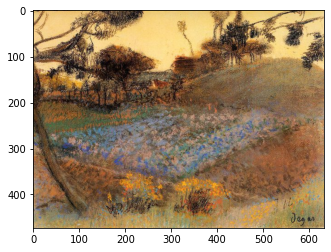

In [4]:
from PIL import Image

img16 = Image.open(dataset_paths[16], mode="r")
plt.imshow(img16)

Look at the image you just displayed:  
📝 Store its shape in `img_shape`  
📝 Store its number of dimensions in `img_dim`

In [18]:
img_shape = img16.size
img_shape

(633, 473)

In [14]:
img16.mode

'RGB'

In [15]:
img_dim = 3

📝 Uncomment the true statements about the image you just displayed

In [16]:
#is_portrait = True
is_portrait = False

is_colored_image = True
#is_colored_image = False

💾 **Run the cell below to submit your results**

In [19]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'image_data_loading',
    img_shape=img_shape,
    img_dim=img_dim,
    is_portrait=is_portrait,
    is_colored_image=is_colored_image
)

result.write()

## 2. Processing (50min)

*C14 Convertir les données entrantes (images et texte par exemple) en données adaptées pour un réseau de neurones (100%)*

📝 Store all images from the dataset folder in a `list` of `ndarray` called **dataset_images**

💡 It can take a while

In [42]:
dataset_images = []

for image in dataset_paths:
    dataset_images.append(np.array(Image.open(image, mode="r")))

In [25]:
len(dataset_images)

498

### 2.1 Reshape, Resize, Rescale

Simplify your dataset and convert it to a single `ndarray`

💡 Recall that your dataset contains colored and black & white images

📝 Assign to a `list` **image_dimensions** the two possible number of dimensions for your images 

In [43]:
img_dims = set()
for image in dataset_images:
    img_dims.add(len(image.shape))
img_dims

{2, 3}

In [36]:
image_dimensions = [2, 3]

📝 Run the cell below to convert all black & white images into colored ones by duplicating the image on three channels  
💡 This is for convenience, so as to have only 3D arrays

In [44]:
dataset_images = [x if x.ndim==3 else np.repeat(x[:,:,None], 3, axis=2) for x in dataset_images]
set([x.ndim for x in dataset_images])

{3}

📝 Resize your images to make sure they have the same shape  

☑️ Use the method `tensorflow.image.resize`  
☑️ The target size is (height=120 pixels, width=100 pixels)  

In [45]:
dataset_images[0].shape

(970, 720, 3)

In [51]:
from tensorflow.image import resize

images_resized = []
for image in dataset_images:
    image = resize(image, (120, 100))
    images_resized.append(image)

📝 Now that all images have the same shape, store them as a `ndarray` in **dataset_resized**  
☑️ Make sure that the size of **dataset_resized** is $(n_{images},\:height,\:width,\:channels)$

In [56]:
dataset_resized = np.array(images_resized)
dataset_resized.shape

(498, 120, 100, 3)

📝 Store in **dataset_scaled** your scaled images  
☑️ All scaled values should be between $0$ and $1$

In [58]:
dataset_scaled = dataset_resized/255

In [59]:
dataset_scaled[0]

array([[[0.35460785, 0.31549022, 0.29073527],
        [0.3327778 , 0.31382352, 0.28565356],
        [0.349183  , 0.32205883, 0.29583332],
        ...,
        [0.30882353, 0.26854575, 0.2607026 ],
        [0.3371248 , 0.30183068, 0.28222284],
        [0.31177747, 0.29565054, 0.2839185 ]],

       [[0.3992157 , 0.36392158, 0.34431374],
        [0.34514704, 0.30867648, 0.27338237],
        [0.35049018, 0.3112745 , 0.27598038],
        ...,
        [0.29460785, 0.2514706 , 0.2372549 ],
        [0.27407047, 0.2583842 , 0.2466195 ],
        [0.31240004, 0.2810275 , 0.2692628 ]],

       [[0.37374184, 0.33844772, 0.31883988],
        [0.34890527, 0.27870917, 0.2686111 ],
        [0.33243462, 0.2971405 , 0.26968953],
        ...,
        [0.3066994 , 0.2571079 , 0.24052292],
        [0.2968138 , 0.25367653, 0.24348007],
        [0.33494982, 0.32262933, 0.30329937]],

       ...,

       [[0.23145445, 0.21576817, 0.20400347],
        [0.21272905, 0.19312121, 0.17743494],
        [0.18692937, 0

### 2.2 Create (X, y) sets

📝 Run the cell below to add random noise to your images

In [60]:
NOISE_LEVEL = 0.2

dataset_noisy = np.clip(
    dataset_scaled + np.random.normal(
        loc=0,
        scale=NOISE_LEVEL,
        size=dataset_scaled.shape
    ).astype(np.float32),
    0,
    1
)
dataset_noisy.shape

(498, 120, 100, 3)

📝 Plot a noisy image alongside the normal one to visualize the impact of the random noise you just added

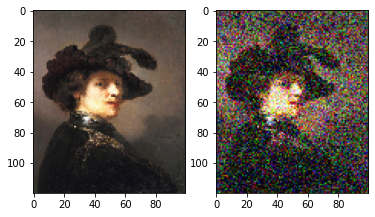

In [64]:
plt.subplot(1,2,1)
plt.imshow(dataset_scaled[0])
plt.subplot(1,2,2)
plt.imshow(dataset_noisy[0]);

📝 **Create your `(X_train, Y_train)`, `(X_test, Y_test)` train and test sets**  
☑️ Use `sklearn`'s `train_test_split` method  
☑️ Your test set should consist of 20% of your total observations, randomly sampled  
💡 Recall your objective: *For a given noisy image $X$, your model should learn to predict the denoised image $y$* to choose $X$ and $y$.

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset_noisy, dataset_scaled, test_size=0.2)
print(X_train.shape)
print(Y_train.shape)

(398, 120, 100, 3)
(398, 120, 100, 3)


💾 **Run the cell below to submit your results**

In [70]:
from nbresult import ChallengeResult
result = ChallengeResult(
    "image_preprocessing",
    X_train_shape = X_train.shape,
    Y_train_shape = Y_train.shape,
    X_std = X_train[:,:,:,0].std(),
    Y_std = Y_train[:,:,:,0].std(),
    first_image = Y_train[0]
)
result.write()

## 3. Convolutional Neural Network (1h10)

*C15 Maîtriser les différentes architectures de réseau de neurones : convolutifs pour les images & récurrents pour les séries temporelles et les modèles de traitement automatique du langage (NLP) pour le texte (50%)*  

*C16 Utiliser un réseau de neurones convolutifs pour étiqueter des images (100%)*

A commonly used neural network architecture for image denoising is the __AutoEncoder__.

<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

Its goal is to learn a compact representation of your data to reconstruct them as precisely as possible.  
The loss for such model must incentivize it to have __an output as close to the input as possible__.

For this challenge, __you will only be asked to code the Encoder part of the network__, since building a Decoder leverages layers architectures you are not familiar with (yet).

**If you haven't managed to build your own (X,Y) training sets**  
📝 Copy and paste the code snippet below in a new cell and run it    
💡 It will give you clean `(X_train, Y_train)`, `(X_test, Y_test)` for this section

```python
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

import pickle
with open("data_painting_solution.pickle", "rb") as file:
    (X_train, Y_train, X_test, Y_test) = pickle.load(file)
    
! rm data_painting_solution.pickle
```

In [71]:
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

import pickle
with open("data_painting_solution.pickle", "rb") as file:
    (X_train, Y_train, X_test, Y_test) = pickle.load(file)

! rm data_painting_solution.pickle

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  136M  100  136M    0     0  1207k      0  0:01:56  0:01:56 --:--:-- 1213k


### 3.1 Architecture

📝 Run the cell below that defines the **decoder**

In [82]:
from tensorflow.keras import Sequential, layers
# We choose to compress images into a latent_dimension of size 6000
latent_dimensions = 6000

# We build a decoder that takes 1D-vectors of size 6000 to reconstruct images of shape (120,100,3)
decoder = Sequential(name='decoder')
decoder.add(layers.Reshape((30, 25, 8), input_dim=latent_dimensions))
decoder.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid"))
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 30, 25, 8)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 60, 50, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 120, 100, 32)     4640      
 ranspose)                                                       
                                                                 
 conv2d_7 (Conv2D)           (None, 120, 100, 3)       867       
                                                                 
Total params: 6,675
Trainable params: 6,675
Non-trainable params: 0
_________________________________________________________________


📝 Store in **encoder** a model defined using `Sequential` that plugs correctly with the **decoder** defined above  

☑️ The output of your **encoder**, before flattening, is the same shape as the input of the **decoder**  
☑️ Use a convolutional neural network architecture without transfer learning  
☑️ Keep it simple  
☑️ Print model summary

In [85]:
encoder = Sequential(name='encoder')

encoder.add(Conv2D(8, (2), input_shape=(120,100,3), activation='relu'))
encoder.add(MaxPooling2D(2))

encoder.add(Conv2D(16, (2), activation='relu'))
encoder.add(MaxPooling2D(2))

encoder.add(Conv2D(32, (2), activation='relu'))
encoder.add(MaxPooling2D(2))

encoder.add(Flatten())
encoder.add(Dense(latent_dimensions, activation='tanh'))

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 119, 99, 8)        104       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 59, 49, 8)        0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 58, 48, 16)        528       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 29, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 23, 32)        2080      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 11, 32)       0   

📝 Run the cell below to construct the full **autoencoder**  
☑️ Look carefully at the summary to make sure your **encoder** fits with the **decoder**

In [80]:
from tensorflow.keras import Model

In [103]:
x = layers.Input(shape=(120, 100, 3))
autoencoder = Model(x, decoder(encoder(x)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 120, 100, 3)]     0         
                                                                 
 encoder (Sequential)        (None, 6000)              29576712  
                                                                 
 decoder (Sequential)        (None, 120, 100, 3)       6675      
                                                                 
Total params: 29,583,387
Trainable params: 29,583,387
Non-trainable params: 0
_________________________________________________________________


### 3.2 Training

📝 Store in **score_baseline** your baseline score  
☑️ Use the Mean Absolute Error  
☑️ Your baseline is the *'dumb'* case where you don't manage to denoise anything at all  

In [119]:
y_pred = np.mean(X_train)

abs_err_baseline = [np.abs(y_true-y_pred) for y_true in Y_test]
score_baseline = np.mean(abs_err_baseline)

score_baseline

0.24177799

📝 Train your **autoencoder**

☑️ Use an appropriate loss for the task at hand  
☑️ Make sure your model does not overfit

💡 You will not be judged by the computing power of your computer, your training should last under 3 minutes

In [104]:
autoencoder.compile(loss='mae', optimizer='adam', metrics='mae')

In [101]:
es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_mae', verbose = 0)

In [105]:
history = autoencoder.fit(X_train, Y_train, 
                          validation_split = 0.3,
                          epochs = 100,
                          batch_size=32,
                          callbacks = [es],
                          verbose=1)

Epoch 1/100
9/9 [==============================] - 5s 526ms/step - loss: 0.1214 - mae: 0.1214 - val_loss: 0.1312 - val_mae: 0.1312
Epoch 2/100
9/9 [==============================] - 4s 482ms/step - loss: 0.1117 - mae: 0.1117 - val_loss: 0.1274 - val_mae: 0.1274
Epoch 3/100
9/9 [==============================] - 4s 447ms/step - loss: 0.1070 - mae: 0.1070 - val_loss: 0.1239 - val_mae: 0.1239
Epoch 4/100
9/9 [==============================] - 4s 458ms/step - loss: 0.1046 - mae: 0.1046 - val_loss: 0.1226 - val_mae: 0.1226
Epoch 5/100
9/9 [==============================] - 4s 433ms/step - loss: 0.1033 - mae: 0.1033 - val_loss: 0.1228 - val_mae: 0.1228
Epoch 6/100
9/9 [==============================] - 4s 491ms/step - loss: 0.1022 - mae: 0.1022 - val_loss: 0.1224 - val_mae: 0.1224
Epoch 7/100
9/9 [==============================] - 5s 525ms/step - loss: 0.1009 - mae: 0.1009 - val_loss: 0.1232 - val_mae: 0.1232
Epoch 8/100
9/9 [==============================] - 5s 619ms/step - loss: 0.1001 - m

📝 Plot your training and validation loss at each epoch  
☑️ Save your figure as **history_cnn.png** in the **tests/** directory  
☑️ Make sure to keep the code below at the end of the cell that contains your plots  
```python
fig = plt.gcf()
fig.savefig("tests/history_cnn.png")
```

In [111]:
def plot_history(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,0.3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('Model MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,0.3))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)


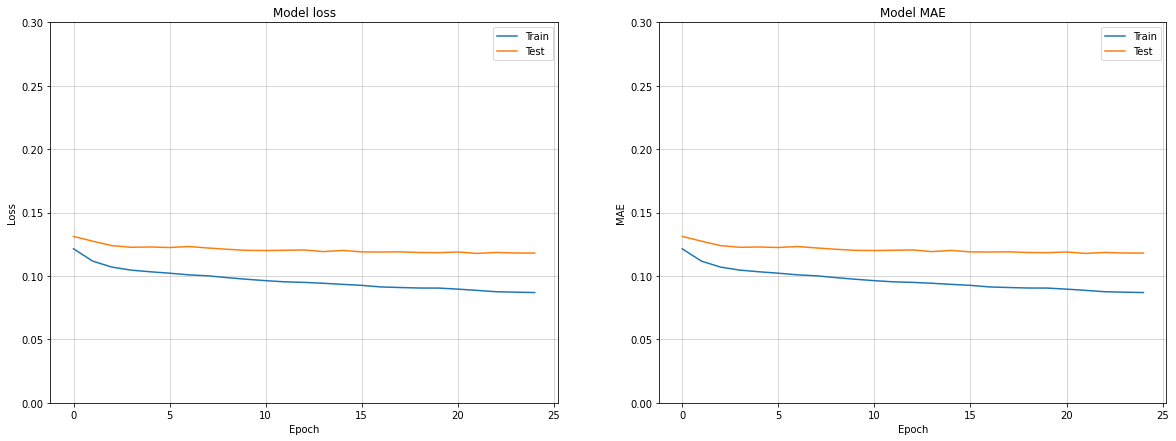

In [113]:
plot_history(history)

# Run this code to save your figure as png in the tests folder
fig = plt.gcf()
fig.savefig("tests/history_cnn.png")

📝 Evaluate your performances on your test set  
☑️ Store in **Y_pred** your denoised test set  
☑️ Store in **score_test** your Mean Absolute Error using **Y_pred** and **Y_test**

In [106]:
Y_pred = autoencoder.predict(X_test, verbose=1)

4/4 [==============================] - 0s 73ms/step


In [107]:
abs_err_test = [np.abs(y_true-Y_pred) for y_true in Y_test]
score_test = np.mean(abs_err_test)
score_test

0.29722646

📝 Run the cell below to check your result on several image  
💡 We asked for a small model, so don't worry if your prediction seems in significantly lower quality than the original

In [114]:
from ipywidgets import interact

@interact(index=range(X_test.shape[0]))
def plot(index):
    idx = index

    fig, axs = plt.subplots(1,3, figsize=(10,5))
    axs[0].imshow(Y_test[idx])
    axs[0].set_title("Clean image.")

    axs[1].imshow(X_test[idx])
    axs[1].set_title("Noisy image.")

    axs[2].imshow(Y_pred[idx])
    axs[2].set_title("Prediction.")

interactive(children=(Dropdown(description='index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

📝 Choose one of your predicted denoised image and save it  
☑️ The target path is **tests/image_denoised.png**

In [117]:
plt.imsave('tests/image_denoised.png', Y_pred[0])

💾 **Run the cell below to submit your results**

In [120]:
from nbresult import ChallengeResult
from tensorflow import size

result = ChallengeResult(
    "image_network",
    input_shape = list(encoder.input.shape),
    output_shape = list(encoder.output.shape),
    layer_names = [layer.name for layer in encoder.layers],
    trainable_params = sum([size(w_matrix).numpy() for w_matrix in encoder.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()

# 🎙️ Lyrics detector Challenge (1h)

🎯 Design and train a lyrics classifier  
☑️ For a given verse $X$, your model should learn to predict the artist $y$  
💡 For this challenge the data processing is given

💡 This challenge assesses the following skills:
- C15 Maîtriser les différentes architectures de réseau de neurones : convolutifs pour les images & récurrents pour les séries temporelles et les modèles de traitement automatique du langage (NLP) pour le texte (50%)
- C17 Utiliser un réseau de neurones pour comprendre l'intention d'une phrase en langage naturel (100%)

## 0. Imports

☑️ Use the cell below to load the packages you use in this challenge  
💡 All packages used in the (given) preprocessing are imported here, make sure to not delete them

In [170]:
# Arrays
import numpy as np
import pandas as pd

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Processing
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

# Model
from sklearn.model_selection import train_test_split

## 1. Load Data (given)  

📝 Let's download the dataset  
☑️ Keep the original, unaltered data in **raw_data** and work with its copy, **data**  
💡 It contains around 4k verses of lyrics from 3 different artists (Drake, Ed Sheeran and Kanye West)

In [171]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy()
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


📝  Look at the 19th verse  
💡 Notice the unicode characters, for instance `\u2005`

In [172]:
raw_data.verse[18]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

📝 Run the cell below to decode unicode characters  
💡 We provide you with a method using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/) to do so  
☑️ Install the `unidecode` package if needed

In [173]:
!pip install unidecode

In [174]:
from unidecode import unidecode
data["verse"] = data["verse"].map(unidecode)
data.verse[18]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

📝 Run the cell below to drop duplicated verses    
💡 Observing duplicates happens quite often with music lyrics  

In [175]:
# Number of duplicated verses
data.duplicated().sum()

944

In [176]:
# Drop duplicated verses
data.drop_duplicates(inplace=True)

# Check again to ensure there are 0 duplicates remaining
data.duplicated().sum()

0

💾 **Run the cell below to submit your results**

In [177]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'lyrics_data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Processing (given)

☑️ For this section, read carefully before running the cells, you will need to understand the processing to design an train your model

📝 Transform the list of strings (verses) into a list of word sequences  
💡 These sequences of words are stored in a new column *seq* in your **data**  
💡 We use `tensorflow.keras.preprocessing.text.text_to_word_sequence` to achieve this

In [178]:
data["seq"] = [text_to_word_sequence(verse) for verse in data["verse"]]

📝 Check the distribution of sequences lengths  
💡 From this we choose to limit ourself to 300 words per verse

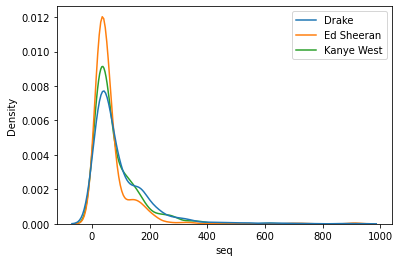

In [179]:
sns.kdeplot(x=data["seq"].map(lambda l: len(l)),
            hue=[x for x in data["artist"]],
            common_norm=False);

📝 Truncate each sequences to keep only the first `300` words

In [180]:
data["seq"] = data["seq"].map(lambda x: x[:300])

📝 Train a `gensim.models.Word2Vec` model on your dataset
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [181]:
from gensim.models import Word2Vec

word2vec = Word2Vec(
    sentences=data["seq"],
    vector_size=100,
    window=5,
    min_count=0,
    epochs=50, 
)

In [182]:
data['embed'] = [[word2vec.wv[word] for word in verse] 
                 for verse in data['seq']]
data

,artist,verse,seq,embed
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]","[[1.4099536, 1.8490736, -0.17796753, -1.608688..."
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[1.413309, -3.2764633, -2.4153738, 0.49378768..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you...","[[1.6250268, 0.92148894, -0.07503409, -0.88544..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a...","[[-0.09267148, -0.91219693, 0.024462799, 1.907..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[1.413309, -3.2764633, -2.4153738, 0.49378768..."
...,...,...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol...","[dame, was, like, yo, you, got, a, deal, with,...","[[-0.16516085, 0.32680938, 0.7630676, 0.122504..."
3971,Kanye West,"Then one day I just went ahead and played it, ...","[then, one, day, i, just, went, ahead, and, pl...","[[0.60782254, 0.2124402, 2.318183, -2.2170413,..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot.""","[i, ain't, gonna, front, it's, kinda, hot]","[[1.6250268, 0.92148894, -0.07503409, -0.88544..."
3973,Kanye West,Like they still weren't looking at me like a r...,"[like, they, still, weren't, looking, at, me, ...","[[-1.6272503, 3.1840997, -0.26413852, 0.672985..."


📝  Create your a `ndarray` **X** of shape $(number\_of\_verses,\ maximum\_sequence\_length,\ embedding\_size)$

💡 Keep 300 words per verse (verses shorter than 300 are padded with zeros at the end) 

In [183]:
X = pad_sequences(
    data["embed"],
    dtype='float',
    padding='post'
)
X.shape

(3031, 300, 100)

📝  Create your a `ndarray` **y** of shape $(number\_of\_verses,\ number\_of\_classes)$ that contains the one-hot encoded list of labels 

In [184]:
y = OneHotEncoder().fit_transform(data[['artist']]).toarray()
y.shape

(3031, 3)

📝 Split the dataset to create both the train and test sets

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

💾 **Run the cell below to submit your results**

In [186]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'lyrics_data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 3. Recurrent Neural Network

*C15 Maîtriser les différentes architectures de réseau de neurones : convolutifs pour les images & récurrents pour les séries temporelles et les modèles de traitement automatique du langage (NLP) pour le texte (50%)*  

*C17 Utiliser un réseau de neurones pour comprendre l'intention d'une phrase en langage naturel (100%)*

📝 Store in **score_baseline** your baseline score  
☑️ Use the Accuracy  
☑️ Your baseline is the 'dumb' case where you predict only the most frequent artist

In [187]:
data['artist'].mode()

0    Drake
dtype: object

In [188]:
score_baseline = len(data[data['artist']=='Drake'])/len(data)
score_baseline

0.45892444737710325

📝 Store in **model** using `Sequential`
❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

☑️ Use a recurrent neural network architecture  
☑️ Keep it simple: use only one LSTM or GRU layer  
☑️ Limit yourself to one *hidden* dense layer between the LSTM/GRU layer and the output layer  
☑️ Don't forget to take care of the fake "zeros" added when padding

In [189]:
model = Sequential()

model.add(layers.Masking(mask_value=-1, input_shape= X_train.shape[1:]))
model.add(layers.LSTM(10, input_shape=X_train.shape[1:],
                              return_sequences=True)) 
model.add(layers.SimpleRNN(3, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_4 (Masking)         (None, 300, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 300, 10)           4440      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 3)                 42        
                                                                 
 dense_6 (Dense)             (None, 1)                 4         
                                                                 
Total params: 4,486
Trainable params: 4,486
Non-trainable params: 0
_________________________________________________________________


📝 Train your **model**

☑️ Use an appropriate loss for the task at hand  
☑️ Make sure your model does not overfit

💡 You will not be judged by the computing power of your computer, your training should last under 3 minutes

In [190]:
model.compile(loss='mse', optimizer='rmsprop', metrics='mae')

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks = [es])

Epoch 1/50
76/76 [==============================] - 15s 152ms/step - loss: 0.2242 - mae: 0.4531
Epoch 2/50
76/76 [==============================] - 12s 159ms/step - loss: 0.2223 - mae: 0.4443
Epoch 3/50
76/76 [==============================] - 12s 156ms/step - loss: 0.2222 - mae: 0.4444
Epoch 4/50
76/76 [==============================] - 13s 170ms/step - loss: 0.2222 - mae: 0.4444
Epoch 5/50
76/76 [==============================] - 12s 159ms/step - loss: 0.2222 - mae: 0.4444
Epoch 6/50
76/76 [==============================] - 13s 169ms/step - loss: 0.2222 - mae: 0.4445
Epoch 7/50
76/76 [==============================] - 14s 185ms/step - loss: 0.2222 - mae: 0.4444
Epoch 8/50
76/76 [==============================] - 12s 161ms/step - loss: 0.2222 - mae: 0.4444
Epoch 9/50
76/76 [==============================] - 12s 155ms/step - loss: 0.2222 - mae: 0.4444
Epoch 10/50
76/76 [==============================] - 12s 160ms/step - loss: 0.2222 - mae: 0.4444
Epoch 11/50
76/76 [====================

In [ ]:
history.history.keys()

📝 Plot your training and validation loss at each epoch  
☑️ Save your figure as **history_rnn.png** in the **tests/** directory  
☑️ Make sure to keep the code below at the end of the cell that contains your plots  
```python
fig = plt.gcf()
fig.savefig("tests/history_rnn.png")
```

In [ ]:
def plot_history(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,0.3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('Model MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,0.3))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

In [ ]:
# Plot below your train/val loss history
plot_history(history)

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history_rnn.png")

📝 Evaluate your performances on your test set  
☑️ Use the `evaluate` method a `Sequential` model to do so  
☑️ Store the resulting accuracy score in **score_test**

In [ ]:
score_test = model.evaluate(X_test, y_test)

💾 **Run the cell below to submit your results**

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "lyrics_network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()